In [ ]:
# Install latest pre-release version of bigdl-chronos 
# Installing bigdl-chronos from pip will automatically install pyspark, bigdl, and their dependencies.
!pip install --pre --upgrade bigdl-chronos[all]
!pip uninstall -y torchtext # uninstall torchtext to avoid version conflict
exit() # restart the runtime to refresh installed pkg

In [ ]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def plot_predict_actual_values(date, y_pred, y_test, ylabel):
    """
    plot the predicted values and actual values (for the test data)
    """
    plt.figure(figsize=(10,5))

    plt.plot(date, y_pred, color='red', label='VCB daily price Predicted')
    plt.plot(date, y_test, color='blue', label='VCB daily price Raw')

    plt.xlabel('Time period')
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

In [ ]:
from bigdl.orca.automl import hp
from bigdl.orca import init_orca_context

In [ ]:
init_orca_context(cores=4, init_ray_on_spark=True)

Initializing orca context
Current pyspark location is : /usr/local/lib/python3.7/dist-packages/pyspark/__init__.py
Start to getOrCreate SparkContext
pyspark_submit_args is:  --driver-class-path /usr/local/lib/python3.7/dist-packages/bigdl/share/dllib/lib/bigdl-dllib-spark_2.4.6-0.14.0-SNAPSHOT-jar-with-dependencies.jar:/usr/local/lib/python3.7/dist-packages/bigdl/share/orca/lib/bigdl-orca-spark_2.4.6-0.14.0-SNAPSHOT-jar-with-dependencies.jar pyspark-shell 
Successfully got a SparkContext


2022-01-29 13:24:58,618	INFO services.py:1340 -- View the Ray dashboard at http://172.28.0.2:8265


{'node_ip_address': '172.28.0.2', 'raylet_ip_address': '172.28.0.2', 'redis_address': '172.28.0.2:6379', 'object_store_address': '/tmp/ray/session_2022-01-29_13-24-55_218850_245/sockets/plasma_store', 'raylet_socket_name': '/tmp/ray/session_2022-01-29_13-24-55_218850_245/sockets/raylet', 'webui_url': '172.28.0.2:8265', 'session_dir': '/tmp/ray/session_2022-01-29_13-24-55_218850_245', 'metrics_export_port': 52048, 'node_id': '254fd6e8beeef0a5daf2109fe6f88c7e93e52f0485fe4182838fc71d'}


<SparkContext master=local[4] appName=pyspark-shell>

In [ ]:
import pandas as pd
import urllib.request
import json
import math

## Get data

In [ ]:
f = open('/content/stock_prices.json')
 
# returns JSON object as
# a dictionary
data = json.load(f)
 
# Iterating through the json
# list
with open('data.json', 'w') as f:
    json.dump(data['data'], f)

data = pd.read_json('data.json')
data

,code,date,time,floor,type,basicPrice,ceilingPrice,floorPrice,open,high,low,close,average,adOpen,adHigh,adLow,adClose,adAverage,nmVolume,nmValue,ptVolume,ptValue,change,adChange,pctChange
0,VCB,2022-01-20,15:01:03,HOSE,STOCK,86.8,92.8,80.8,85.2,87.5,83.1,87.1,85.660,85.200,87.500,83.100,87.100,85.660,2794300,239372970000,0,0,0.3,0.3000,0.3456
1,VCB,2022-01-19,15:01:02,HOSE,STOCK,87.6,93.7,81.5,87.5,87.5,85.0,86.8,86.330,87.500,87.500,85.000,86.800,86.330,914800,78972420000,500000,41500000000,-0.8,-0.8000,-0.9132
2,VCB,2022-01-18,15:01:03,HOSE,STOCK,86.2,92.2,80.2,85.5,87.6,84.0,87.6,86.350,85.500,87.600,84.000,87.600,86.350,1696600,146506850000,39000,3412500000,1.4,1.4000,1.6241
3,VCB,2022-01-17,15:01:03,HOSE,STOCK,83.4,89.2,77.6,83.0,88.0,82.3,86.2,85.640,83.000,88.000,82.300,86.200,85.640,2628500,225104290000,40030,3476541000,2.8,2.8000,3.3573
4,VCB,2022-01-14,15:01:03,HOSE,STOCK,81.9,87.6,76.2,81.9,83.4,81.0,83.4,82.770,81.900,83.400,81.000,83.400,82.770,1522100,125980020000,30000,2307000000,1.5,1.5000,1.8315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2254,VCB,2013-01-08,14:01:05,HOSE,STOCK,30.0,31.5,28.5,30.6,31.5,30.1,31.5,30.809,12.872,13.251,12.663,13.251,12.959,1035220,31894000000,0,0,1.5,0.6310,5.0000
2255,VCB,2013-01-07,14:01:04,HOSE,STOCK,29.2,30.6,27.8,28.0,30.0,28.0,30.0,29.373,11.779,12.620,11.779,12.620,12.357,1312740,38559000000,0,0,0.8,0.3365,2.7397
2256,VCB,2013-01-04,14:01:07,HOSE,STOCK,28.5,29.9,27.1,28.0,29.5,27.8,29.2,28.821,11.779,12.410,11.695,12.283,12.124,501540,14455000000,0,0,0.7,0.2945,2.4561
2257,VCB,2013-01-03,14:01:06,HOSE,STOCK,27.8,29.1,26.5,27.9,28.5,27.0,28.5,28.050,11.737,11.989,11.358,11.989,11.801,500650,14043000000,0,0,0.7,0.2945,2.5180


In [ ]:
data.sort_values(by="date", ignore_index=True, inplace=True)

In [ ]:
df = pd.DataFrame(pd.to_datetime(data.date))

# we can find 'AvgRate' is of two scales: 'Mbps' and 'Gbps'
# raw_df.AvgRate.str[-4:].unique() 

# Unify AvgRate value
# df["basicPrice"] = data["basicPrice"]
df['close'] = data['close']

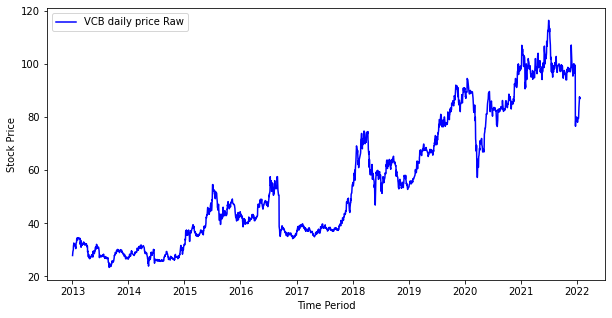

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10, 5))
plt.plot(data.date, data.close, color='blue', label='VCB daily price Raw')
plt.xlabel("Time Period")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

## Feature Engineering & Data Preperation

In [ ]:
from bigdl.chronos.data import TSDataset
from sklearn.preprocessing import MinMaxScaler

# we look back one week data which is of the frequency of 2h.
# look_back = 84
# specify the number of steps to be predicted，one day is selected by default.
# horizon = 12

tsdata_train, tsdata_val, tsdata_test = TSDataset.from_pandas(df, dt_col="date", target_col=["close"], with_split=True,val_ratio=0.1, test_ratio=0.1)
minmax_scaler = MinMaxScaler()

for tsdata in [tsdata_train, tsdata_test]:
    tsdata.impute(mode="last")\
          .scale(minmax_scaler, fit=(tsdata is tsdata_train))\
          .roll(lookback=50, horizon=1)

x_train, y_train = tsdata_train.to_numpy()
x_test, y_test = tsdata_test.to_numpy()
x_train.shape, y_train.shape, x_test.shape, y_test.shape

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


((1759, 50, 1), (1759, 1, 1), (175, 50, 1), (175, 1, 1))

## Time series forecasting

In [ ]:
from bigdl.chronos.forecaster.tcn_forecaster import TCNForecaster
forecaster = TCNForecaster(past_seq_len = 50,
                           future_seq_len = 1,
                           input_feature_num = x_train.shape[-1],
                           output_feature_num = 1,                        
                           repo_initialization = False,
                           kernel_size = 5, 
                           dropout = 0.1, 
                           lr = 0.002,
                           seed = 0,
                           distributed = True)

(PytorchRayWorker pid=627) /usr/local/lib/python3.7/dist-packages/bigdl/chronos/forecaster/__init__.py:36: UserWarning: Please install `tensorflow<2.0.0` to use MTNetForecaster.
(PytorchRayWorker pid=627)   warnings.warn("Please install `tensorflow<2.0.0` to use MTNetForecaster.")
(PytorchRayWorker pid=627) /usr/local/lib/python3.7/dist-packages/bigdl/chronos/forecaster/__init__.py:41: UserWarning: Please install `prophet` to use ProphetForecaster.
(PytorchRayWorker pid=627)   warnings.warn("Please install `prophet` to use ProphetForecaster.")
(PytorchRayWorker pid=627) /usr/local/lib/python3.7/dist-packages/bigdl/chronos/forecaster/__init__.py:46: UserWarning: Please install `pmdarima` to use ARIMAForecaster.
(PytorchRayWorker pid=627)   warnings.warn("Please install `pmdarima` to use ARIMAForecaster.")


In [ ]:
forecaster.data_config, forecaster.model_config

({'future_seq_len': 1,
  'input_feature_num': 1,
  'output_feature_num': 1,
  'past_seq_len': 50},
 {'dropout': 0.05,
  'kernel_size': 5,
  'num_channels': [30, 30, 30, 30, 30, 30, 30],
  'repo_initialization': False})

(PytorchRayWorker pid=627) [2022-01-29 13:53:15] INFO     Added key: store_based_barrier_key:1 to store for rank: 0
(PytorchRayWorker pid=627) [2022-01-29 13:53:15] INFO     Rank 0: Completed store-based barrier for 1 nodes.


In [ ]:
%%time
forecaster.fit((x_train, y_train), epochs=50, batch_size=16)

(PytorchRayWorker pid=627) /usr/local/lib/python3.7/dist-packages/bigdl/chronos/forecaster/utils.py:33: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
(PytorchRayWorker pid=627)   return DataLoader(TensorDataset(torch.from_numpy(data[0]).float(),
 98%|█████████▊| 54/55 [00:13<00:00,  3.92batch/s, loss=0.0181]
[2022-01-29 13:53:29] INFO     Finished training epoch 1, stats on rank 0: {'epoch': 1, 'batch_count': 55, 'num_samples': 1759, 'train_loss': 0.2738934977519082, 'last_train_loss': 0.018713312223553658}
 98%|█████████▊| 54/55 [00:09<00:00,  5.43batch/s, loss=0.0205]
[2022-01-29 1

CPU times: user 23.4 s, sys: 3.81 s, total: 27.2 s
Wall time: 8min 54s


 98%|█████████▊| 54/55 [00:10<00:00,  5.06batch/s, loss=0.00285]


[{'batch_count': 55,
  'epoch': 1,
  'last_train_loss': 0.018713312223553658,
  'num_samples': 1759,
  'train_loss': 0.2738934977519082},
 {'batch_count': 55,
  'epoch': 2,
  'last_train_loss': 0.015539553947746754,
  'num_samples': 1759,
  'train_loss': 0.017360564913746816},
 {'batch_count': 55,
  'epoch': 3,
  'last_train_loss': 0.008753117173910141,
  'num_samples': 1759,
  'train_loss': 0.01577329687507333},
 {'batch_count': 55,
  'epoch': 4,
  'last_train_loss': 0.0089506721124053,
  'num_samples': 1759,
  'train_loss': 0.015658732302986707},
 {'batch_count': 55,
  'epoch': 5,
  'last_train_loss': 0.010913633741438389,
  'num_samples': 1759,
  'train_loss': 0.014295677384419865},
 {'batch_count': 55,
  'epoch': 6,
  'last_train_loss': 0.007691128645092249,
  'num_samples': 1759,
  'train_loss': 0.014619340353199048},
 {'batch_count': 55,
  'epoch': 7,
  'last_train_loss': 0.009414700791239738,
  'num_samples': 1759,
  'train_loss': 0.013966289644869232},
 {'batch_count': 55,
  'e

[2022-01-29 14:02:09] INFO     Finished training epoch 50, stats on rank 0: {'epoch': 50, 'batch_count': 55, 'num_samples': 1759, 'train_loss': 0.004152348256315729, 'last_train_loss': 0.0031779692508280277}


In [ ]:
forecaster.to_local()

In [ ]:
# make prediction
y_pred = forecaster.predict(x_test)

In [ ]:
y_pred_unscale = tsdata_test.unscale_numpy(y_pred)
y_test_unscale = tsdata_test.unscale_numpy(y_test)

In [ ]:
from bigdl.orca.automl.metrics import Evaluator
print("RMSE", Evaluator.evaluate("rmse", y_test_unscale, y_pred_unscale, multioutput='uniform_average'))
print("MAPE", Evaluator.evaluate("mape", y_test_unscale, y_pred_unscale, multioutput='uniform_average'))

RMSE 12.447788720903969
MAPE 10.935360825080043


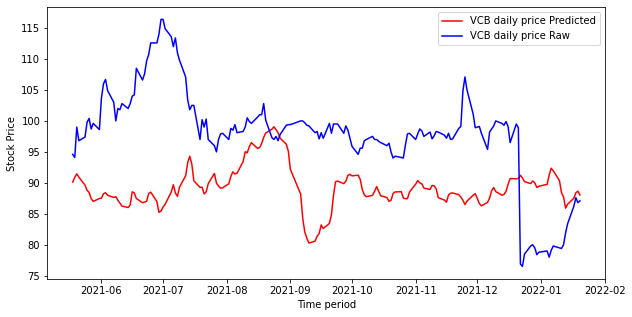

In [ ]:
target_name = "Stock Price"
target_index = 0
plot_predict_actual_values(date=tsdata_test.df.date[50:], y_pred=y_pred_unscale[:, 0, target_index], y_test=y_test_unscale[:, 0, target_index], ylabel=target_name)